# Task 3 Activation Map Reconstruction main give up


## PLAN

### 1.1 Dataset Instruction

Download the dataset from the [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) by running following command: 

```bash
source download_intracardiac_dataset.sh
```

### 1.2 Task Description

*Understand the time when each part of the heart is activated.*

The objective is to build a model that can predict the activation times at the 75 myocardial points based on the ECG data from the 12 leads.

### 1.3 Load Modules and Preprocessing Functions

In [18]:
# Analysis
import numpy as np
import pandas as pd

import glob, re, os
from typing import List

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Evaluate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Data processing
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import LabelEncoder
# from sklearn.model_selection import train_test_split

# Ignore warning
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 100)
plt.style.use('ggplot')

In [19]:
# Run the cardiac_ml_tools.py script
%run ../cardiac_challenge/notebooks/cardiac_ml_tools.py

In [20]:
# Load the dataset
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR = '../cardiac_challenge/intracardiac_dataset/' # path to the intracardiac_dataset

for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))


Number of file pairs: 16117
Example of file pair:
../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_3_bcl/pECGData_hearts_dd_0p2_geo_act_3_bcl_bcl.1000.pattern.0.volunteer.v1.npy
../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_3_bcl/VmData_hearts_dd_0p2_geo_act_3_bcl_bcl.1000.pattern.0.volunteer.v1.npy


### 1.4 Dataset details


The dataset [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) 
consists of pairs of computationally simulated intracardiac transmembrane voltage recordings and ECG signals.
In total, 16140 organ-level simulations were conducted to create this dataset.
Simulations were performed using Lassen supercomputer at Lawrence Livermore National Lab (LLNL), concurrently utilizing 4 GPUs and 40 CPU cores.
Each simulation produced pairs of 500ms-by-10 raw electrode signals and 500ms-by-75 transmembrane voltage signals.
For convenience, we collect those signals in matrices and give them the following names:

Tensor | Description | Shape | Notes
--- | --- | --- | ---
$X$ | Row electrode signals | $10 \times 500$ | 10-lead ECG signals from the simulated torso (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$V$ | Activation map | $75 \times 500$ | Transmembrane voltage signals from the simulated heart (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$E$ | 12-lead ECG signals | $12 \times 500$ | 12-lead ECG signals obtained by `get_standard_leads`($X$)
$A$ | Activation map | $75 \times 1$ | Activation time, defined as $A_i = \text{min}_j(V_{ij})$

**IMPORTANT** : The raw data in the dataset consists of 10-lead ECG signals and 75-lead transmembrane voltage signals. The 12-lead ECG signals are obtained from the 10-lead ECG signals using the function `get_standard_leads` (in the file `cardiac_ml_tools.py`).

The overall generation process is shown in the following image. The ECG signal is recorded using 10 virtual electrodes and the transmembrane voltages are recorded at 75 points within the myocardium. The transmembrane voltages are then used to generate the spatio-temporal activation maps.

![if picture not show, see path "/cardiac_challenge/figures/data_generation.png"](../cardiac_challenge/figures/data_generation.png)

## ANALYZE

### 2.1 Getting the standard 12-lead ECG from the 10-lead ECG

The function `get_standard_leads` (in the file `cardiac_ml_tools.py`) is used to obtain the 12-lead ECG signals from the 10-lead ECG signals. It implements the following transformation, where the (Wilson Lead) is defined as $Vw = 1/3*(RA + LA + LL)$:
$$
\left\{
\begin{array}{lll}
    X_{:,1}  & \to  & RA \\
    X_{:,2}  & \to  & LA \\
    X_{:,3}  & \to  & LL \\
    X_{:,4}  & \to  & RL \\
    X_{:,5}  & \to  & V1 \\
    X_{:,6}  & \to  & V2 \\
    X_{:,7}  & \to  & V3 \\
    X_{:,8}  & \to  & V4 \\
    X_{:,9}  & \to  & V5 \\
    X_{:,10} & \to &  V6 \\
\end{array}
\right.
\text{        and        }
\left\{
\begin{array}{lll}          
\text{Lead } I& : & LA - RA \\
\text{Lead } II& : & LL - RA \\
\text{Lead } III& : & LL - LA \\
\text{Lead } aVR& : &  \frac{3}{2} (RA - Vw) \\
\text{Lead } aVL& : &  \frac{3}{2} (LA - Vw) \\
\text{Lead } aVF& : &  \frac{3}{2} (LL - Vw)\\ 
\text{Lead } V1 & : & V1 - Vw \\
\text{Lead } V2 & : & V2 - Vw \\
\text{Lead } V3 & : & V3 - Vw \\
\text{Lead } V4 & : & V4 - Vw \\
\text{Lead } V5 & : & V5 - Vw \\
\text{Lead } V6 & : & V6 - Vw \\
\end{array}
\right.
$$

Case 213 : ../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_3_bcl/pECGData_hearts_dd_0p2_geo_act_3_bcl_bcl.1000.pattern.21.volunteer.v12.npy


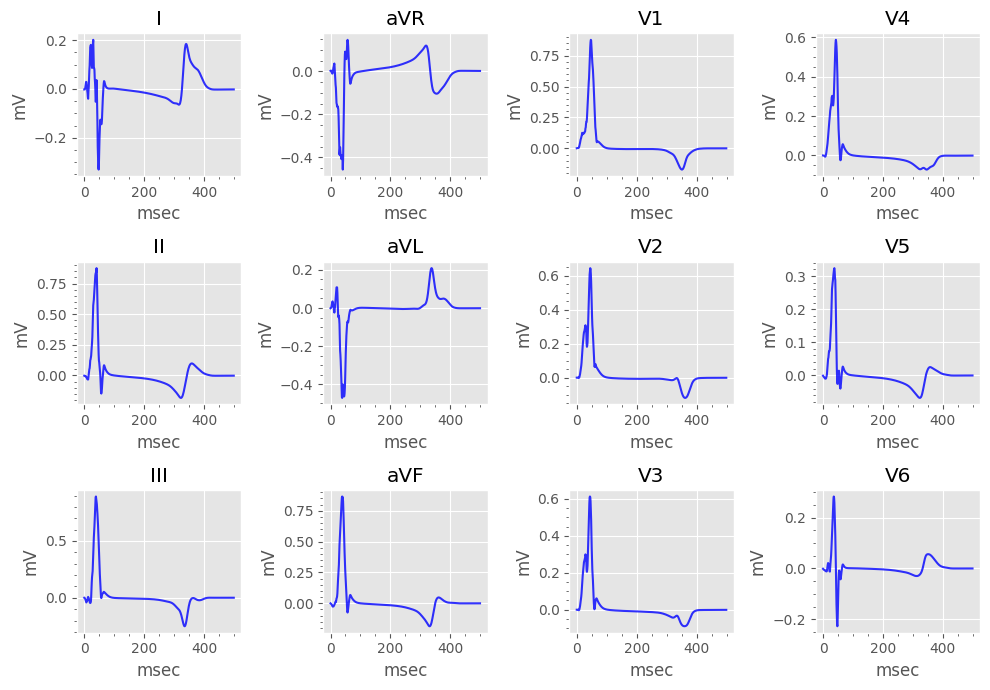

In [21]:
# Example of file pair
case = 213
# ECG plot
row = 3 
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1:1,2:5,3:9,4:2,5:6,6:10,7:3,8:7,9:11,10:4,11:8,12:12} # reorder the leads to standard 12-lead ECG display

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

# create a figure with 12 subplots
for i in range(pECGData.shape[1]):
    plt.subplot(row, column, reorder[i + 1])
    plt.plot(pECGData[0:num_timesteps,i],'r', color='blue', alpha=0.8)
    plt.title(titles[i])
    # plt.plot(visible=True, color='blue', linestyle='-')
    plt.minorticks_on()
    # plt.plot(visible=True, color='blue', linestyle='-', alpha=0.2)
    plt.xlabel('msec')
    plt.ylabel('mV')
plt.tight_layout()
plt.show()
# close
plt.close()

### 2.2 Getting the activation map from the transmembrane voltages

The funtion `get_activation_map` (in the file `cardiac_ml_tools.py`) is used to obtain the activation map from the transmembrane voltages. It implements the following transformation $A_i = \text{min}_j(V_{ij})$.

Case 213 : ../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_3_bcl/pECGData_hearts_dd_0p2_geo_act_3_bcl_bcl.1000.pattern.21.volunteer.v12.npy


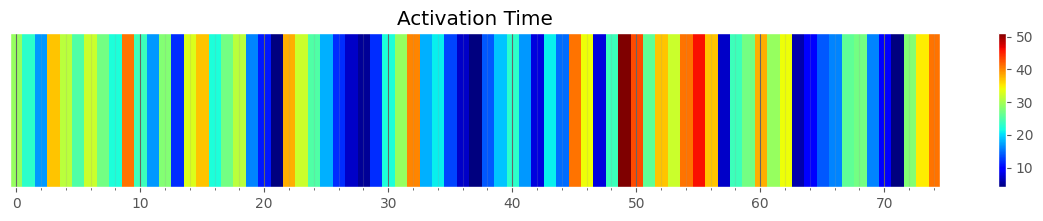

In [22]:
# Example of file pair
case = 213
# plt.figure(figsize=(1, 10))
plt.figure(figsize=(15, 2))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])

ActTime = get_activation_time(VmData)

# plot the Activation Time array
plt.imshow(ActTime.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('Activation Time')
plt.colorbar()
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
# not yticks
plt.yticks([])
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()


### 3.3 Learning the mapping from the 12-lead ECG to the activation map

Case 213 : ../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_3_bcl/pECGData_hearts_dd_0p2_geo_act_3_bcl_bcl.1000.pattern.21.volunteer.v12.npy
Case 213 : ../cardiac_challenge/intracardiac_dataset/data_hearts_dd_0p2_geo_act_3_bcl/pECGData_hearts_dd_0p2_geo_act_3_bcl_bcl.1000.pattern.21.volunteer.v12.npy


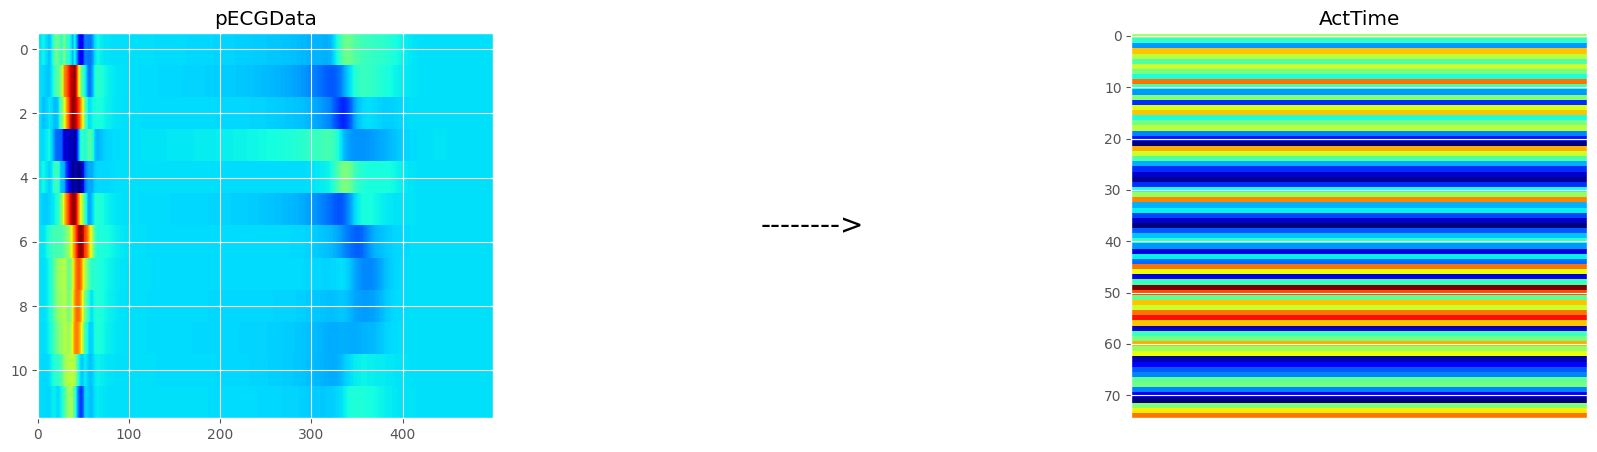

In [23]:
# make a plot with the "pECGData" -> "ActTime"
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])
ActTime = get_activation_time(VmData)

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print an arrow
plt.text(0.5, 0.5, '-------->', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.axis('off')
plt.subplot(row, column, 3)
# plot ActTime
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
# not xticks
plt.xticks([])
plt.title('ActTime')
plt.show()
plt.close()

**Tricks**

As in many machine learning problems, normalization of the data might be helpful or even necessary. Different normalization schemes might be applied.

## CONSTRUCT

**Model: 1D CNN**

**Approach**

We to flatten each 2D sample (12x500) from the ECG data into a 1D row, transforming each sample from a matrix into a long vector. Then, you want to stack all these vectors from over 16,000 samples into a single large dataset where each row represents one sample, fully flattened, resulting in a dataset with dimensions of (16000, 6000) — since 12 x 500 = 6000.

Here’s the step-by-step plan to achieve this:

1. **Flatten Each Sample**: Each 12x500 matrix will be reshaped into a single row of 6000 elements. This converts the 2D feature set of each sample into a 1D array.

2. **Stack All Samples**: After flattening each sample, you'll stack them vertically to create a new dataset where each row corresponds to one of the original 2D samples, now represented as a long 1D vector.

3. **Create a Uniform Dataset**: The result will be a large dataset where every sample is consistently formatted in a single row, making it easier to handle in terms of data processing and input into machine learning models.

4. **Store or Process This Dataset**: Depending on the final application, this dataset can then be either stored for further use, processed for normalization, or directly used as input for machine learning models, particularly for tasks like clustering, classification, or regression.

This approach effectively transforms a complex 2D dataset into a more manageable 1D format, albeit at the expense of increasing the dimensionality of each data point. This can be useful for certain types of analyses or machine learning models that require a flat vector per sample.

**Combine Dataset Approach**

Given that your full dataset contains over 16,000 samples, here's a graduated approach to determining an initial subset size:

- **Initial Proof of Concept**: Start with a very small amount of data, perhaps around **100 to 500 samples**. This size is usually sufficient to ensure that your data loading, processing, and model training pipelines are functioning correctly without excessive computational overhead.

- **Preliminary Testing**: Once your initial setup is verified to be working correctly, increase the size to about **1,000 to 2,000 samples**. This provides a more statistically significant dataset to start tuning hyperparameters and testing model performance while still being manageable in terms of computational resources and time.

- **Detailed Testing and Validation**: If the model performs well on 1,000 to 2,000 samples, consider using a larger subset, such as **5,000 to 10,000 samples**, to further refine your model and prepare for full-scale training. This step is crucial for understanding how well the model scales with data size and for final adjustments before deploying the model on the entire dataset.

### 3.1 Data Processing

In [ ]:
# file_pairs is a list where each element is a tuple containing the file paths for ECG data and activation time data
num_samples = 500  # Number of samples to process
num_timesteps = 500  # Each ECG data has 500 timesteps
num_leads = 12  # Standard ECG leads count after processing

# Initialize arrays to store combined data
ECGData_500 = np.zeros((num_samples, num_timesteps * num_leads))  # Flattened array for 12 leads data
ActTime_500 = np.zeros((num_samples, 75))  # Store 75 activation times per sample

# Process each sample
for i in range(num_samples):
    # Load ECG data
    pECGData = np.load(file_pairs[i][0])
    pECGData = get_standard_leads(pECGData)  # Convert to 12 standard leads
    ECGData_500[i, :] = pECGData.flatten()  # Flatten and store in the combined array

    # Load activation time data
    VmData = np.load(file_pairs[i][1])
    ActTime = get_activation_time(VmData)
    ActTime_500[i, :] = ActTime.flatten()  # Flatten the (75, 1) array to fit into (75,) array


In [ ]:
# Create directory if it does not exist
output_dir = '../combine_dataset'
os.makedirs(output_dir, exist_ok=True)

# Save combined datasets to .npy format
np.save(os.path.join(output_dir, 'ecg_data_500.npy'), ECGData_500)
np.save(os.path.join(output_dir, 'active_time_500.npy'), ActTime_500)


After combine, check them

In [ ]:
print("ECGData_500 shape: {}".format(ECGData_500.shape))
print("ActTime_500 shape: {}".format(ActTime_500.shape))

Split Dataset

In [ ]:
# Shuffle indices
indices = np.arange(ECGData_500.shape[0])
shuffled_indices = shuffle(indices, random_state=42)

# Define the split point
split_ratio = 0.8  # 80% train, 20% test
split_point = int(len(shuffled_indices) * split_ratio)

# Split indices into training and test sets
train_indices = shuffled_indices[:split_point]
test_indices = shuffled_indices[split_point:]

# Use indices to create training and test data
X_train = ECGData_500[train_indices]
y_train = ActTime_500[train_indices]
X_test = ECGData_500[test_indices]
y_test = ActTime_500[test_indices]

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

build model

In [ ]:
class Simple1DCNN(nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()

        # convolutional layers -> relu -> convolutional layers -> relu -> pooling -> flatten -> fully connected layers
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=16, kernel_size=3, padding=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=2)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool1d(3)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(5376, 512)
        self.relu3 = nn.ReLU()
        # 32 channels * 1500 length
        self.fc2 = nn.Linear(512, 75)  # Output the activation times
        # # Layer 1: First convolutional layer
        # self.conv1 = nn.Conv1d(in_channels=12, out_channels=16, kernel_size=5, padding=2)
        # # Layer 2: ReLU activation function
        # self.relu = nn.ReLU()
        # # Layer 3: Max pooling layer
        # self.pool = nn.MaxPool1d(2)
        # # Layer 4: Second convolutional layer
        # self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, padding=2)
        # # Layer 5: First fully connected layer
        # self.fc1 = nn.Linear(32*1500, 100)
        # # Layer 6: Second fully connected layer
        # self.fc2 = nn.Linear(100, 75)  # Output the activation times


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        # print(x.size())  # This will print the shape [batch_size, num_channels, length]
        # x = x.view(x.size(0), -1)  # Flatten the output for the dense layer
        # print(x.size())  # This will print the flattened size
        return x


In [ ]:
nbmerge Task_3_Activation_Map_Reconstruction.ipynb Task_3_Activation_Map_Reconstruction_Cont_1.ipynb > merged.ipynb